In [3]:
# Import statements
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler
import random
import os
import sys
project_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_path)

# Data Pre Processing

In [4]:
from utils.air_quality_pre_processor import AirQualityProcessor
# Load Beijing Multisite Air Quality Data
Aoti_data = pd.read_csv('../data/air_quality_cluster/PRSA_Data_Aotizhongxin_20130301-20170228.csv');
# Example data
processed_aoti_data = AirQualityProcessor(Aoti_data)
forecast_columns = processed_aoti_data.preprocess_airquality_data()


## Simulate industrial Data

TODOs:

1. Predict PM2.5 using other exogenous features

2. Downsample PM2.5

3. Break in 4 tasks

4. Translate

### Original Data Visualization

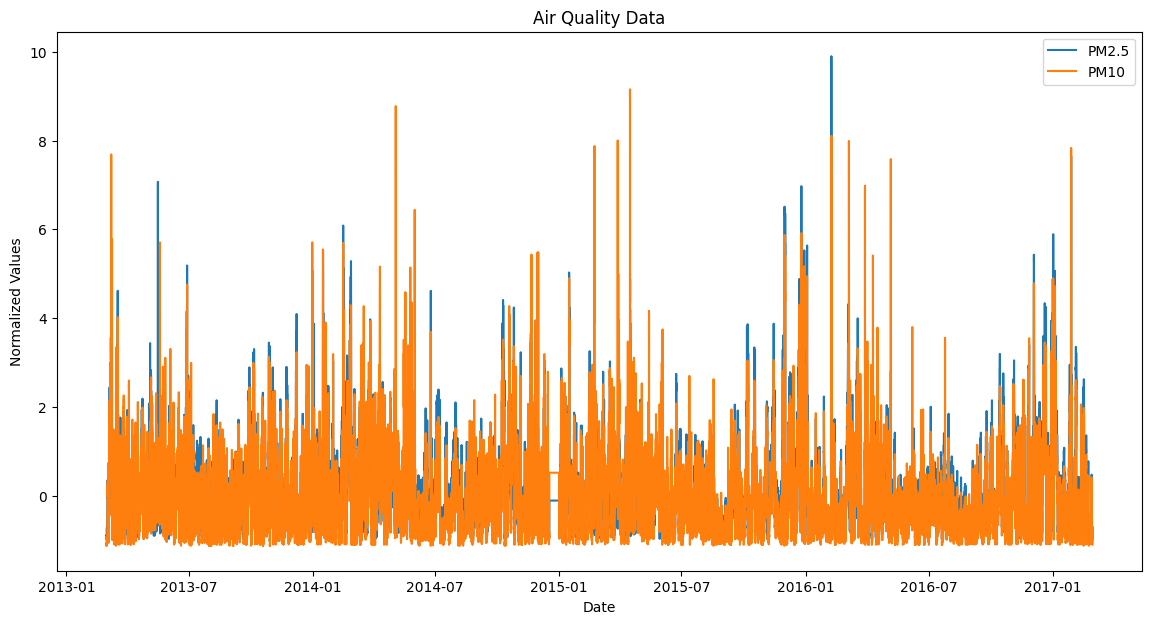

In [44]:
# Plot the data date vs PM2.5, PM10, SO2, NO2, CO, O3
plt.figure(figsize=(14, 7))
plt.plot(Aoti_data['date'], Aoti_data['PM2.5'], label='PM2.5')
plt.plot(Aoti_data['date'], Aoti_data['PM10'], label='PM10')
plt.xlabel('Date')
plt.ylabel('Normalized Values')
plt.title('Air Quality Data')
plt.legend()
plt.show()

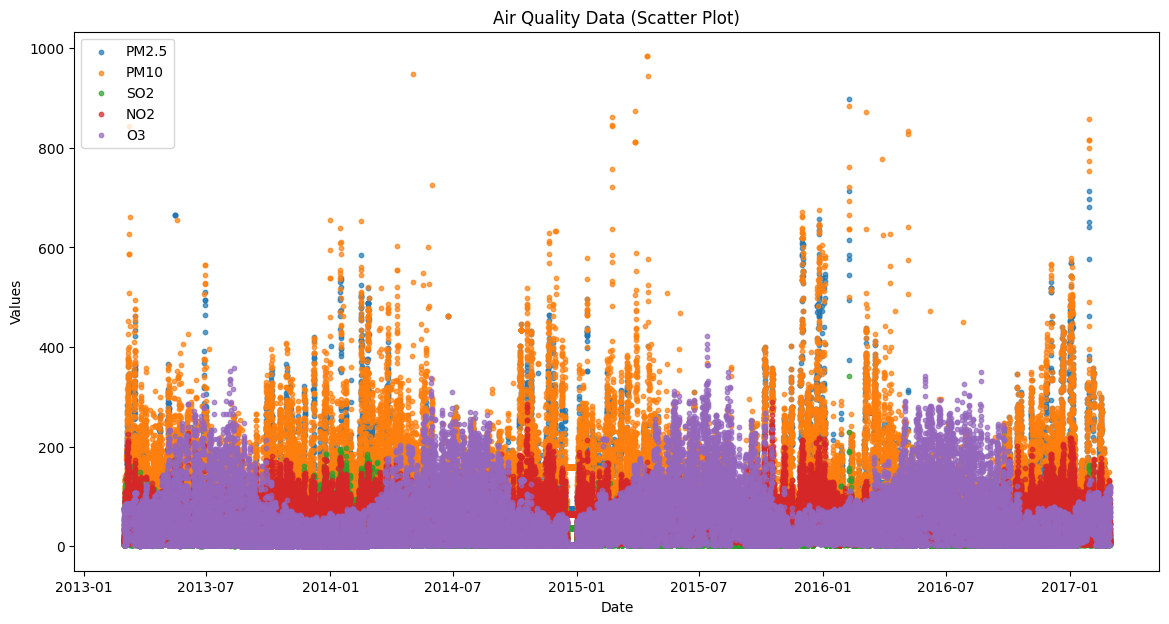

In [32]:
# Scatter plot for date vs PM2.5 and PM10 and SO2, NO2, CO, O3
plt.figure(figsize=(14, 7))
plt.scatter(Aoti_data['date'], Aoti_data['PM2.5'], label='PM2.5', alpha=0.7, s=10)
plt.scatter(Aoti_data['date'], Aoti_data['PM10'], label='PM10', alpha=0.7, s=10)
plt.scatter(Aoti_data['date'], Aoti_data['SO2'], label='SO2', alpha=0.7, s=10)
plt.scatter(Aoti_data['date'], Aoti_data['NO2'], label='NO2', alpha=0.7, s=10)
# plt.scatter(Aoti_data['date'], Aoti_data['CO'], label='CO', alpha=0.7, s=10)
plt.scatter(Aoti_data['date'], Aoti_data['O3'], label='O3', alpha=0.7, s=10)

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Air Quality Data (Scatter Plot)')
plt.legend()
plt.show()

In [45]:
# Print Date Range
print('Date Range: ', Aoti_data['date'].min(), ' to ', Aoti_data['date'].max())

Date Range:  2013-03-01 00:00:00  to  2017-02-28 23:00:00


In [46]:
# Get data for row 2013-03-01 00:00:00
print(Aoti_data[Aoti_data['date'] == '2013-03-01 00:00:00'])

        date     PM2.5      PM10       SO2       NO2        CO        O3  \
0 2013-03-01 -0.962014 -1.119098 -0.594822 -1.412992 -0.778576  0.378863   

       TEMP     PRES     DEWP      RAIN      WSPM  
0 -1.252733  1.07146 -1.60114 -0.074064  2.235205  


In [47]:
# get Frequency of data
print('Frequency of data: ', Aoti_data['date'].diff().value_counts())

Frequency of data:  0 days 01:00:00    35063
Name: date, dtype: int64


### Resample PM2.5 to a lower frequency.

In [79]:
Aoti_data.head()

,date,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM
0,2013-03-01 00:00:00,-0.962014,-1.119098,-0.594822,-1.412992,-0.778576,0.378863,-1.252733,1.071460,-1.601140,-0.074064,2.235205
1,2013-03-01 01:00:00,-0.913405,-1.077158,-0.594822,-1.412992,-0.778576,0.378863,-1.287819,1.090682,-1.557314,-0.074064,2.484342
2,2013-03-01 02:00:00,-0.925557,-1.087643,-0.550998,-1.331926,-0.778576,0.309396,-1.287819,1.119515,-1.557314,-0.074064,3.231755
3,2013-03-01 03:00:00,-0.937709,-1.098128,-0.288059,-1.304905,-0.778576,0.292030,-1.314133,1.215625,-1.644967,-0.074064,1.155608
4,2013-03-01 04:00:00,-0.974166,-1.129583,-0.244236,-1.277883,-0.778576,0.292030,-1.366762,1.282902,-1.652271,-0.074064,0.242103


In [91]:
# Downsample the PM2.5 column to a 3-day frequency.
Aoti_data.set_index('date', inplace=True)
Aoti_data_resampled_pm25 = Aoti_data['PM2.5'].resample('3D').mean()
Aoti_data['PM2.5_3D'] = Aoti_data_resampled_pm25.reindex(Aoti_data.index)
Aoti_data.reset_index(inplace=True)


### Breaking Data in Multiple Tasks

In [93]:
# Split The Dataset into 4 parts, 2013-03-01 to 2014-02-28, 2014-03-01 to 2015-02-28, 2015-03-01 to 2016-02-29, 2016-03-01 to 2017-02-28
data_2013 = Aoti_data[(Aoti_data['date'] >= '2013-03-01') & (Aoti_data['date'] <= '2014-02-28')]
data_2014 = Aoti_data[(Aoti_data['date'] >= '2014-03-01') & (Aoti_data['date'] <= '2015-02-28')]
data_2015 = Aoti_data[(Aoti_data['date'] >= '2015-03-01') & (Aoti_data['date'] <= '2016-02-29')]
data_2016 = Aoti_data[(Aoti_data['date'] >= '2016-03-01') & (Aoti_data['date'] <= '2017-02-28')]

Assign Unique id to each partition

In [94]:
# Assign a unique cluster_id to each dataset
data_2013['cluster_id'] = 1
data_2014['cluster_id'] = 2
data_2015['cluster_id'] = 3
data_2016['cluster_id'] = 4

/var/folders/n2/ynmqlkx14wd993676tgwybz80000gn/T/ipykernel_37005/611746620.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2013['cluster_id'] = 1
/var/folders/n2/ynmqlkx14wd993676tgwybz80000gn/T/ipykernel_37005/611746620.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2014['cluster_id'] = 2
/var/folders/n2/ynmqlkx14wd993676tgwybz80000gn/T/ipykernel_37005/611746620.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

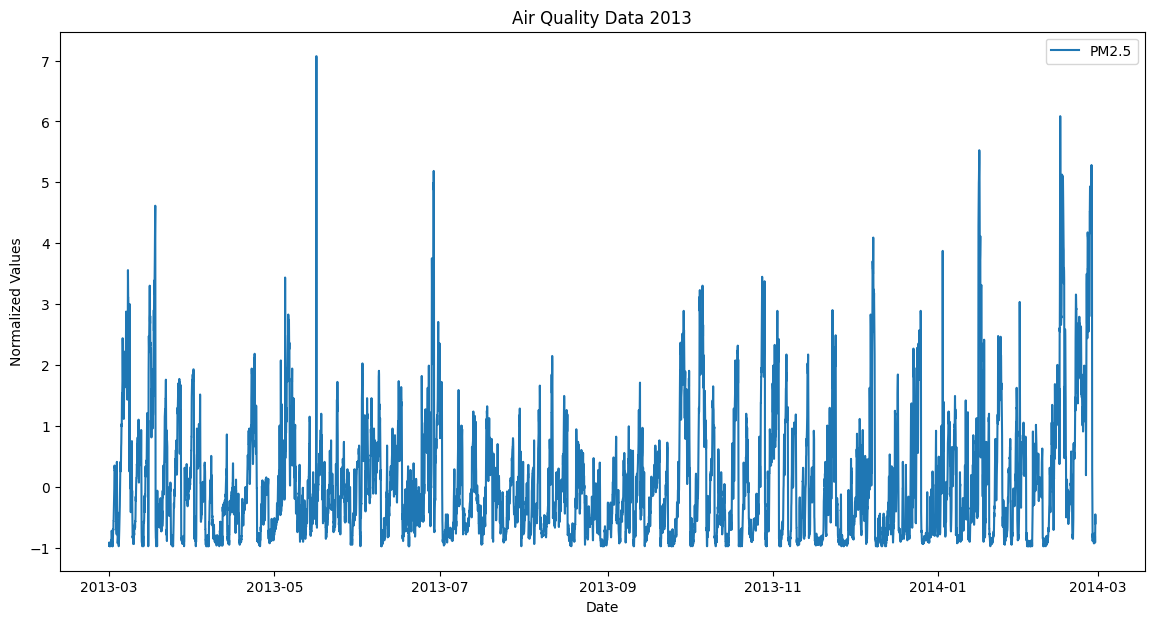

In [96]:
# Plot the data date vs PM2.5, PM10, SO2, NO2, CO, O3, TEMP, PRES, DEWP, RAIN, WSPM, for 2013, 2014, 2015, 2016
plt.figure(figsize=(14, 7))
plt.plot(data_2013['date'], data_2013['PM2.5'], label='PM2.5')
plt.plot(data_2013['date'], data_2013['PM10'], label='PM10')
plt.plot(data_2013['date'], data_2013['SO2'], label='SO2')
plt.xlabel('Date')
plt.ylabel('Normalized Values')
plt.title('Air Quality Data 2013')
plt.legend()

### Random Translation to Simulate Repairs

In [97]:
# Generate random translation values
random_up_2014 = np.random.uniform(10, 20)  # Translate up by 10-20 units
random_down_2015 = np.random.uniform(-20, -10)  # Translate down by 10-20 units
random_up_2016 = np.random.uniform(5, 15)  # Translate up by 5-15 units

# apply translation to all columns of 2014, 2015, 2016 data
data_2014[forecast_columns] += random_up_2014
data_2015[forecast_columns] += random_down_2015
data_2016[forecast_columns] += random_up_2016

/var/folders/n2/ynmqlkx14wd993676tgwybz80000gn/T/ipykernel_37005/2939188892.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2014[forecast_columns] += random_up_2014
/var/folders/n2/ynmqlkx14wd993676tgwybz80000gn/T/ipykernel_37005/2939188892.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2015[forecast_columns] += random_down_2015
/var/folders/n2/ynmqlkx14wd993676tgwybz80000gn/T/ipykernel_37005/2939188892.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

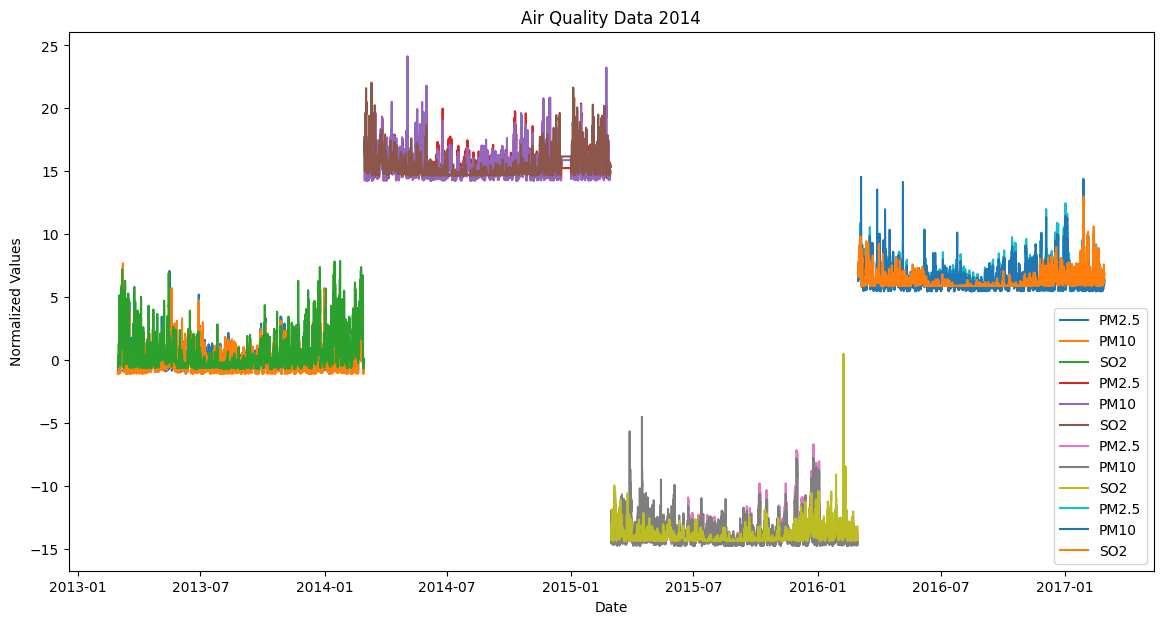

In [101]:
# Plot the data date vs PM2.5, PM10, SO2, NO2, CO, O3, TEMP, PRES, DEWP, RAIN, WSPM, for 2013, 2014, 2015, 2016
plt.figure(figsize=(14, 7))
plt.plot(data_2013['date'], data_2013['PM2.5'], label='PM2.5')
plt.plot(data_2013['date'], data_2013['PM10'], label='PM10')
plt.plot(data_2013['date'], data_2013['SO2'], label='SO2')
plt.plot(data_2014['date'], data_2014['PM2.5'], label='PM2.5')
plt.plot(data_2014['date'], data_2014['PM10'], label='PM10')
plt.plot(data_2014['date'], data_2014['SO2'], label='SO2')
plt.plot(data_2015['date'], data_2015['PM2.5'], label='PM2.5')
plt.plot(data_2015['date'], data_2015['PM10'], label='PM10')
plt.plot(data_2015['date'], data_2015['SO2'], label='SO2')
plt.plot(data_2016['date'], data_2016['PM2.5'], label='PM2.5')
plt.plot(data_2016['date'], data_2016['PM10'], label='PM10')
plt.plot(data_2016['date'], data_2016['SO2'], label='SO2')

plt.xlabel('Date')
plt.ylabel('Normalized Values')
plt.title('Air Quality Data 2014')
plt.legend()

In [73]:
# concatenate the data for 2013, 2014, 2015, 2016
data_translated = pd.concat([data_2013, data_2014, data_2015, data_2016], axis=0)

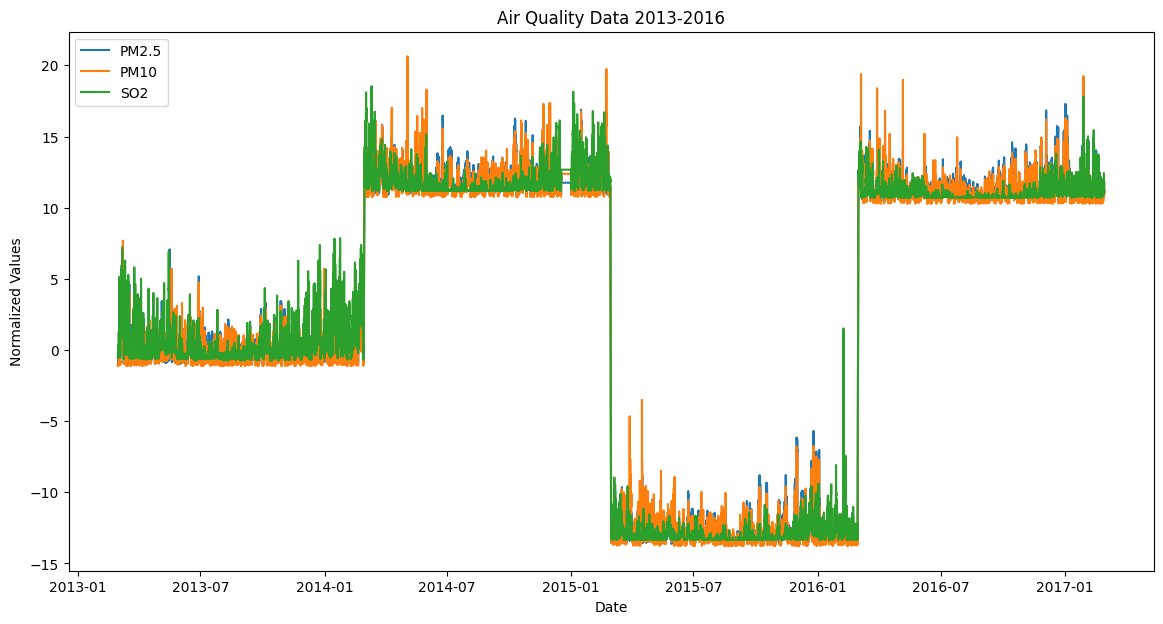

In [74]:
# Plot
plt.figure(figsize=(14, 7))
plt.plot(data_translated['date'], data_translated['PM2.5'], label='PM2.5')
plt.plot(data_translated['date'], data_translated['PM10'], label='PM10')
plt.plot(data_translated['date'], data_translated['SO2'], label='SO2')
plt.xlabel('Date')
plt.ylabel('Normalized Values')
plt.title('Air Quality Data 2013-2016')
plt.legend()

In [166]:
# # Write a Function that does the above steps and saves the data to a csv file
# def generate_simulated_airquality_data(data_path, n_tasks=4):
#     """
#     Generate Air Quality Data with Resampling and Random Translations.

#     Args:
#         data_path (str): Path to the air quality data CSV file.
#         n_tasks (int): Number of tasks (splits) to create in the dataset.

#     Returns:
#         list: List of DataFrames, each corresponding to a task with unique transformations.
#     """
#     # Read the dataset
#     Aoti_data = pd.read_csv(data_path)

#     Aoti_data = AirQualityProcessor(Aoti_data)
#     forecast_columns = Aoti_data.preprocess_airquality_data()
#     Aoti_data =  Aoti_data.data
    
#     # Ensure 'date' is in datetime format
#     Aoti_data['date'] = pd.to_datetime(Aoti_data['date'])
    
#     # Resample PM2.5 to a 3-day frequency
#     Aoti_data.set_index('date', inplace=True)
#     Aoti_data_resampled_pm25 = Aoti_data['PM2.5'].resample('3D').mean()
#     Aoti_data['PM2.5_3D'] = Aoti_data_resampled_pm25.reindex(Aoti_data.index)
#     Aoti_data.reset_index(inplace=True)
    
#     # Split the dataset into `n_tasks` equal parts
#     task_size = len(Aoti_data) // n_tasks
#     task_data = []
    
#     # Dynamically generate translation ranges for each task
#     # Seed for reproducibility
#     random.seed(42)

#     # Define a base range template
#     base_ranges = [(-30, -20), (-40, -10), (10, 20), (5, 15)]

#     # Shuffle the order of base ranges
#     random.shuffle(base_ranges)

#     # Expand or repeat ranges to match the number of tasks, with random factors
#     translation_ranges = [random.choice(base_ranges) for _ in range(n_tasks)]
    
#     for i in range(n_tasks):
#         # Determine start and end indices for the split
#         start_idx = i * task_size
#         end_idx = len(Aoti_data) if i == n_tasks - 1 else (i + 1) * task_size
        
#         # Extract the slice
#         task_slice = Aoti_data.iloc[start_idx:end_idx].copy()
        
#         # Assign a unique cluster_id to each slice
#         task_slice['cluster_id'] = i + 1
        
#         # Apply random translation within the unique range
#         low, high = translation_ranges[i]
#         random_translation = np.random.uniform(low, high)
#         task_slice[forecast_columns] += random_translation
        
#         # Collect the processed task slice
#         task_data.append(task_slice)
    
#     return task_data






In [ ]:
from utils.generate_simulation_data import generate_simulated_time_series

simulated_data = generate_simulated_time_series(processed_aoti_data.data ,date_column="date", columns=forecast_columns ,n_tasks=4, resample_frequency='3D')

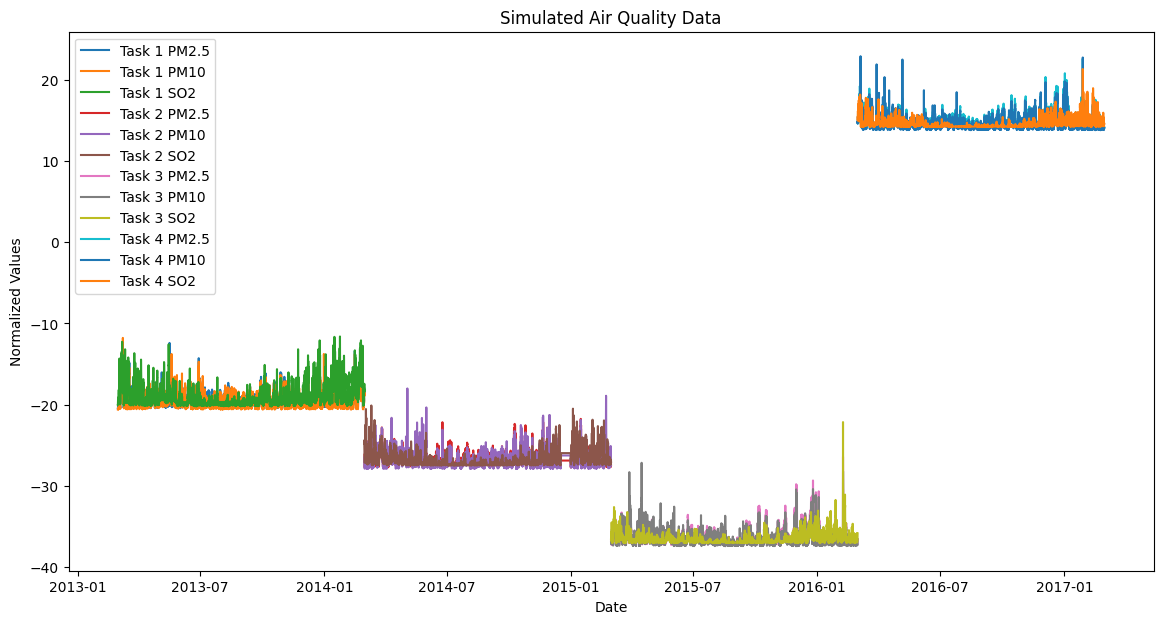

In [171]:
# Plot the data for each task PM2.5, PM10, SO2, NO2
plt.figure(figsize=(14, 7))
# Plot the data for each task PM2.5, PM10, SO2, NO2
for i, task_data in enumerate(simulated_data):
    plt.plot(task_data['date'], task_data['PM2.5'], label=f'Task {i + 1} PM2.5')
    plt.plot(task_data['date'], task_data['PM10'], label=f'Task {i + 1} PM10')
    plt.plot(task_data['date'], task_data['SO2'], label=f'Task {i + 1} SO2')    
    plt.xlabel('Date')
    plt.ylabel('Normalized Values')
    plt.title('Simulated Air Quality Data')
    plt.legend()



## Test Simulation Data Generation on Other Datasets

In [40]:
# Rossman Data
# Load Rossman Sales Data
rossman_data = pd.read_csv('../data/rossman/train.csv')

/var/folders/n2/ynmqlkx14wd993676tgwybz80000gn/T/ipykernel_35747/254183781.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  rossman_data = pd.read_csv('../data/rossman/train.csv')


In [41]:
# data types
rossman_data.dtypes

Store             int64
DayOfWeek         int64
Date             object
Sales             int64
Customers         int64
Open              int64
Promo             int64
StateHoliday     object
SchoolHoliday     int64
dtype: object

In [42]:
# Convert stateHoliday to int 0 or 1
rossman_data['StateHoliday'] = rossman_data['StateHoliday'].map({'0': 0, 'a': 1, 'b': 1, 'c': 1, 0: 0})

In [65]:
rossman_data.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

Text(0.5, 1.0, 'StateHoliday Data')

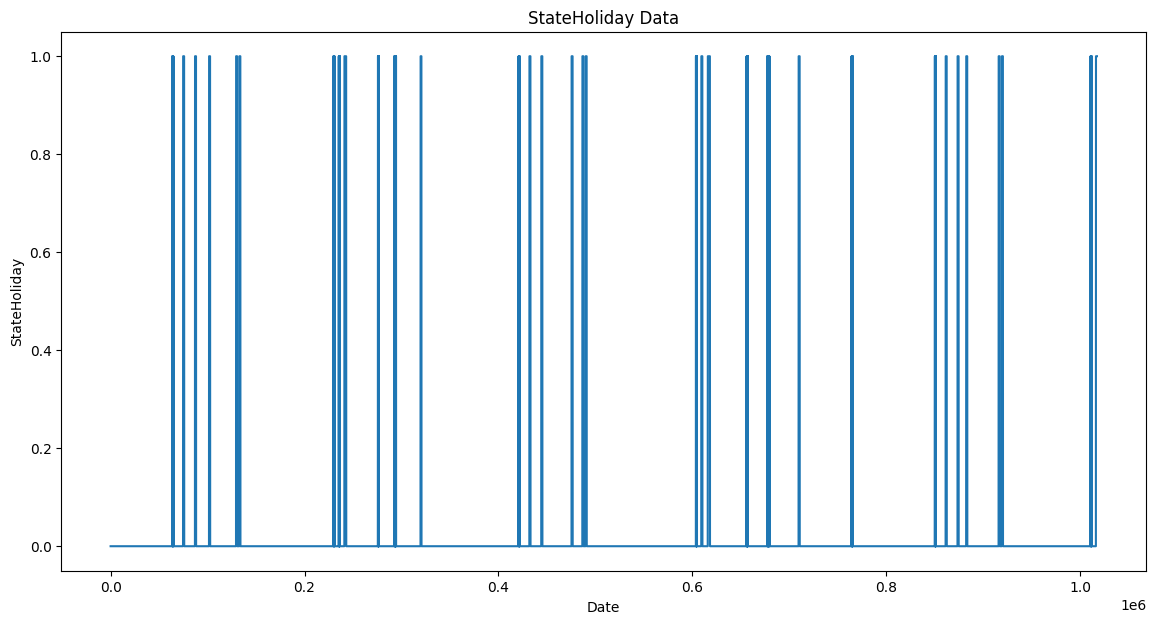

In [58]:
# Plot StateHoliday
plt.figure(figsize=(14, 7))
plt.plot(rossman_data['StateHoliday'])
plt.xlabel('Date')
plt.ylabel('StateHoliday')
plt.title('StateHoliday Data')



In [63]:
# Number of stores 1 
store_1 = rossman_data[rossman_data['Store'] == 1]


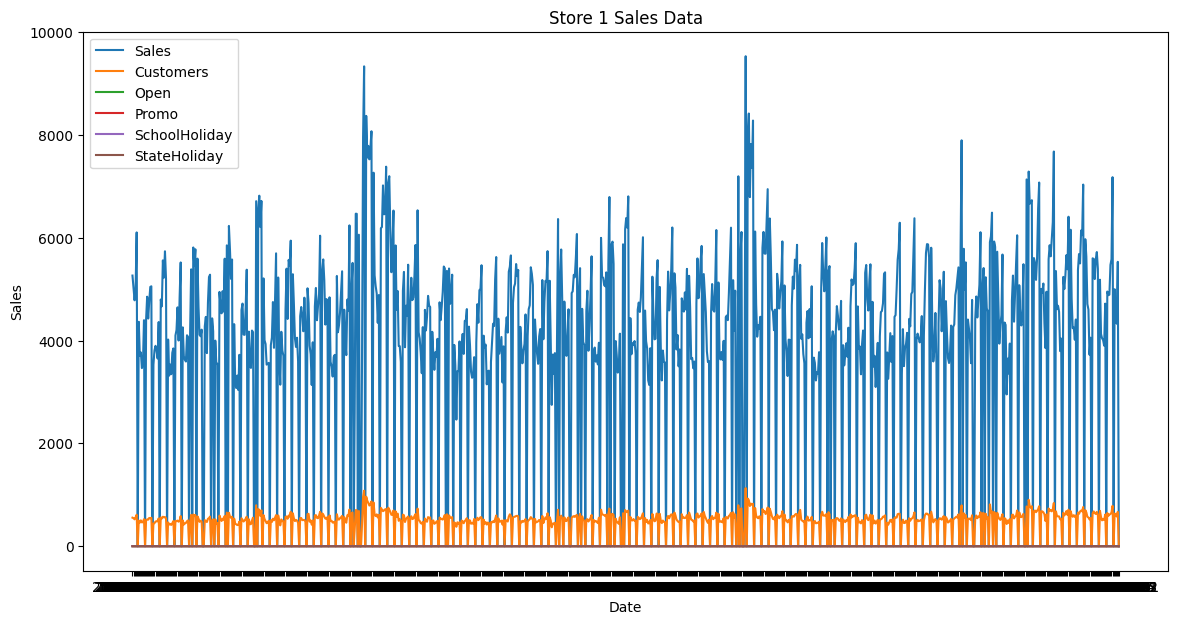

In [62]:
# Plot the data for store 1 sales, customers, open, promo, schoolholiday, stateholiday
plt.figure(figsize=(14, 7))
plt.plot(store_1['Date'], store_1['Sales'], label='Sales')
plt.plot(store_1['Date'], store_1['Customers'], label='Customers')
plt.plot(store_1['Date'], store_1['Open'], label='Open')
plt.plot(store_1['Date'], store_1['Promo'], label='Promo')
plt.plot(store_1['Date'], store_1['SchoolHoliday'], label='SchoolHoliday')
plt.plot(store_1['Date'], store_1['StateHoliday'], label='StateHoliday')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Store 1 Sales Data')
plt.legend()


In [64]:
# create a separate csv for each store
for store_id in rossman_data['Store'].unique():
    store_data = rossman_data[rossman_data['Store'] == store_id]
    store_data.to_csv(f'../data/rossman/cluster_data/store_{store_id}.csv', index=False)

In [ ]:
import joblib
from sklearn.preprocessing import StandardScaler
import pandas as pd


class RossmanDataProcessor:
    def __init__(self, data):
        """
        Initialize the Rossman Data Processor.

        Args:
            data (pd.DataFrame): The Rossman sales dataset.
        """
        self.data = data
        self.forecast_columns = None

    def preprocess_rossman_data(self):
        """
        Preprocess the Rossman Sales dataset.

        Steps:
        1. Parse and process the date column.
        2. Handle missing values.
        3. Feature engineering (e.g., extract date features, map 'StateHoliday', create 'Holiday').
        4. Normalize numerical columns.
        5. Save the scaler for future use.

        Returns:
            list: List of feature columns used for forecasting.
        """
        # Convert 'Date' to datetime and set as index
        self.data['Date'] = pd.to_datetime(self.data['Date'])
        self.data.set_index('Date', inplace=True)

        # Fill missing values
        self.data['Open'].fillna(1, inplace=True)  # Assume stores are open if no information is available
        self.data.fillna(method='ffill', inplace=True)
        self.data.fillna(method='bfill', inplace=True)

        # Map 'StateHoliday' to binary values
        self.data['StateHoliday'] = self.data['StateHoliday'].map({'0': 0, 'a': 1, 'b': 1, 'c': 1, 0: 0})

        # Feature engineering: Create 'Holiday' by combining SchoolHoliday and StateHoliday
        self.data['Holiday'] = self.data.apply(
            lambda row: int(row['SchoolHoliday'] or row['StateHoliday']), axis=1
        )

        # Normalize numerical columns
        numerical_columns = ['Sales', 'Customers', 'Promo']
        scaler = StandardScaler()
        self.data[numerical_columns] = scaler.fit_transform(self.data[numerical_columns])
        joblib.dump(scaler, 'rossman_scaler.pkl')

        # Define forecast columns
        self.forecast_columns = ['Store', 'DayOfWeek', 'Promo', 'Holiday', 'Year', 'Month', 'WeekOfYear', 'Day', 'Sales', 'Customers']
        return self.forecast_columns
